## ==================== Libraries ====================

In [1]:
# Determinadas
import pandas
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# Procesamiento de imágenes
from PIL import Image

## <br><br><br>==================== Functions ====================

### Objetive Function

In [2]:
def objectiveFunction(queens): # 100 fitness máximo
    # Número de reinas.
    n = 8
    
    # Variable de fitness.
    fitness = 100
    
    # Arreglo para verificar repeticiones en las filas.
    repeatedColumns = np.zeros(8) 
    
    # Checar que no se repitan en las filas.
    for i in range(n):
        if repeatedColumns[queens[i]] == 1:
            fitness -= 1
        else:
            repeatedColumns[queens[i]] = 1
    
    
    # Checar que no se repitan en las diagonales por la derecha.
    for i in range(n):
        for j in range(n):
            # Si j es mayor que i.
            if j > i:
                # Diagonal derecha para abajo y para arriba.
                if queens[j] == queens[i]+(j-i) or queens[j] == queens[i]-(j-i):
                    fitness -= 1
            # Si j es menor que i.
            elif j < i:
                # Diagonal izquierda para abajo y para arriba.
                if queens[j] == queens[i]+(i-j) or queens[j] == queens[i]-(i-j):
                    fitness -= 1
                
    return fitness

### Random Element

In [3]:
def getRandomizeElement():
    # Número de reinas.
    n = 8
    
    # Arreglo de posiciones.
    positions = [0,1,2,3,4,5,6,7]
    
    # Arreglo de reinas.
    queens = np.zeros(8, dtype=int)
        
    i = 0
    while len(positions) > 0:
        # Generar número random.
        r = random.randint(0, len(positions) - 1)
        
        # Agregar valor
        queens[i] = positions[r]
        
        # Eliminar elemento de la lista de posiciones.
        del positions[r]
        
        # Aumentar iterador.
        i += 1
    
    
    return queens

### <br><br><br><br>Genetic Algorithm

#### Selection functions

In [4]:
def parentsSelectionByTournament(k, populationList, populationFitness):
    # Obtener el tamaño de la población.
    N = len(populationList)
    
    # Matriz para guardar la población del torneo.
    newPopulation = -1*np.ones(k, dtype=int)
    
    # El mejor elemento de la población.
    better = [0,-100000]

    # Rellenar matriz con nuevos individuos.
    for i in range(k):
        while True:
            # Generar número random.
            r = random.randint(0, N-1)
            
            # Si todavía no ha sido seleccionado dicho individuo.
            if r not in newPopulation:
                # Agregar individuo.
                newPopulation[i] = r
                
                # Si hay una mejora en el fitness.
                if populationFitness[r] > better[1]:
                    # Cambiar el mejor.
                    better = [r,populationFitness[r]]

                break
        
    # El mejor individuo.
    fittestIndividual = populationList[better[0]]
    
    return fittestIndividual

In [5]:
def parentsSelectionByRoulette(k, populationList, populationFitness):
    # Obtener el tamaño de la población.
    N = len(populationList)
    
    # Lista para guardar las proporciones de cada individuo.
    proportionsRange = np.zeros((N,2))
    
    # Total suma de fitness.
    totalFitness = np.sum(populationFitness)
    
    # Poner elemento 0.
    proportionsRange[0] = [0, populationFitness[0] / totalFitness]
    
    # Variable de la suma acumulada. 
    proportionsSum = 0
    
    # Calcular las proporciones.
    for i in range(1,N):
        proportionsSum = proportionsSum + (populationFitness[i-1] / totalFitness)
        proportionsRange[i] = [ proportionsRange[i-1,1], (populationFitness[i] / totalFitness) + proportionsSum ]
        
        
    # Matriz para guardar la población de la ruleta.
    newPopulation = -1*np.ones(k, dtype=int)
    
    # El mejor elemento de la población.
    better = [0,-100000]
    
    # Rellenar 
    for i in range(k):
        # Generar un número random entre 0 y 1.
        randomNumber = np.random.uniform(0, 1, 1)
        
        # Checar qué rango es.
        for j in range(N):
            if( randomNumber >= proportionsRange[j,0] and randomNumber < proportionsRange[j,1] ):
                while True:
                    # Generar número random.
                    r = random.randint(0, N-1)

                    # Si todavía no ha sido seleccionado dicho individuo.
                    if r not in newPopulation:
                        # Agregar individuo.
                        newPopulation[i] = r

                        # Si hay una mejora en el fitness.
                        if populationFitness[r] > better[1]:
                            # Cambiar el mejor.
                            better = [r,populationFitness[r]]

                        break
                    
    # El mejor individuo.
    fittestIndividual = populationList[better[0]]
    
    return fittestIndividual

#### Crossover functions

In [6]:
def simpleCrossover(Pr, k, populationList, populationFitness):
    # Obtener el tamaño de la población.
    N = len(populationList)
    
    # Matriz para guardar la nueva población.
    newPopulation = np.zeros_like(populationList)
    
    for i in range(N):
        # Generar un número random entre 0 y 1.
        r = np.random.uniform(0, 1, 1)
        
        # Si el número random es menor que la Pr.
        if r < Pr:
            # Seleccionar padres.
            # parent1 = parentsSelectionByTournament(k, populationList, populationFitness)
            # parent2 = parentsSelectionByTournament(k, populationList, populationFitness)
            parent1 = parentsSelectionByRoulette(k, populationList, populationFitness)
            parent2 = parentsSelectionByRoulette(k, populationList, populationFitness)
            
            # Dividir en partes a los papás.
            part1 = parent1[:len(parent1)//2]
            part2 = parent2[len(parent2)//2:]
            
            # Obtener al hijo.
            offspring = np.concatenate((part1,part2), axis=None)
            
            # Crear arreglo de zeros para checar cuáles faltan y cuáles nodos ya están.
            checkPositions = range(0,8)
            checkPositions = np.array(checkPositions)
            
            # Crear arreglo de zeros para checar dónde se repiten las posiciones.
            repeatedPositions = []
            
            # Marcar posiciones.
            for j in range(len(offspring)):
                if offspring[j] in checkPositions:
                    checkPositions[offspring[j]] = -1
                else:
                    repeatedPositions.append(j)
                    
            # Eliminar campos con -1.
            checkPositions = checkPositions[checkPositions != -1]
            
            # Aleatorizar el arreglo.
            random.shuffle(checkPositions)
            
            # Poner los nodos faltantes en los que están repetidos.
            for j,m in enumerate(repeatedPositions):
                offspring[m] = checkPositions[j]
                   
            # Agregar a la población.      
            newPopulation[i] = offspring
        else:
            # Seleccionar padre.
            parent = parentsSelectionByTournament(k, populationList, populationFitness)
            # parent = parentsSelectionByRoulette(k, populationList, populationFitness)
            
            # Agregar a la población.      
            newPopulation[i] = parent
            
    return newPopulation

In [7]:
def partialCrossover(Pr, k, populationList, populationFitness):
    # Obtener el tamaña de la población.
    N = len(populationList)
    
    # Matriz para guardar la nueva población.
    newPopulation = np.zeros_like(populationList)
    
    for i in range(N):
        # Generar un número random entre 0 y 1.
        r = np.random.uniform(0, 1, 1)
        
        # Si el número random es menor que la Pr.
        if r < Pr:
            # Seleccionar padres.
            parent1 = parentsSelectionByTournament(k, populationList, populationFitness)
            parent2 = parentsSelectionByTournament(k, populationList, populationFitness)
            # parent1 = parentsSelectionByRoulette(k, populationList, populationFitness)
            # parent2 = parentsSelectionByRoulette(k, populationList, populationFitness)
            
            # Obtener la división
            exactDivision = len(parent1)//3
            
            # Dividir en partes a los papás.
            part1 = parent2[:exactDivision]
            part2 = parent1[exactDivision:exactDivision*2]
            part3 = parent2[exactDivision*2:]
            part4 = parent2[exactDivision:exactDivision*2]
            
            # Crear arreglo donde irá el offspring.
            offspring = -1*np.ones((len(parent1)), dtype=int)
            
            # Copiar elementos del primer padre.
            for j,m in enumerate(range(exactDivision,exactDivision*2)):
                offspring[m] = part2[j]
                
            # Copiar los elementos del segundo padre (primer tercio).
            for j,m in enumerate(range(0,exactDivision)):
                if part1[j] not in offspring:
                    offspring[m] = part1[j]
                    
            # Copiar los elementos del segundo padre (segundo tercio).
            for j,m in enumerate(range(exactDivision*2,len(offspring))):
                if part3[j] not in offspring:
                    offspring[m] = part3[j]
                    
            # Colocar últimos elementos.
            offspringIdx = 0
            for j in range(0,len(part4)):
                if part4[j] not in offspring:
                    for m in range(offspringIdx,len(offspring)):
                        if offspring[m] == -1:
                            offspring[m] = part4[j]
                            offspringIdx = m
                            break
                            
            # Agregar a la población.      
            newPopulation[i] = offspring
        else:
            # Seleccionar padre.
            parent = parentsSelectionByTournament(k, populationList, populationFitness)
            # parent = parentsSelectionByRoulette(k, populationList, populationFitness)

            # Agregar a la población.      
            newPopulation[i] = parent
            
    return newPopulation

#### Mutation function

In [8]:
def swapMutation(Pm, populationList):
    # Obtener el tamaño de la población.
    N = len(populationList)
    
    for i in range(N):
        # Generar un número random entre 0 y 1.
        r = np.random.uniform(0, 1, 1)

        # Si el número random es menor que la Pm.
        if r < Pm:
            # Seleccionar índices random.
            i1 = random.randint(1, len(populationList[i])-1)
            i2 = random.randint(1, len(populationList[i])-1)
            
            # Auxiliar para hacer el intercambio.
            aux = populationList[i,i1]
            
            # Intercambio.
            populationList[i,i1] = populationList[i,i2]
            populationList[i,i2] = aux
            
    return populationList

#### Elite functions

In [9]:
def getElite(populationList):
    # Obtener el tamaño de la población.
    N = len(populationList)
    
    # Poner como elite el primer elemento de momento.
    elite = [populationList[0], objectiveFunction(populationList[0])]
    
    # Obtener el elite.
    for i in range(N):
        # Obtener el fitness del individuo i.
        elementFitness = objectiveFunction(populationList[i])
        
        # Si el fitness del individuo i es mayor que el fitness del elite.
        if( elementFitness > elite[1] ):
            elite = [populationList[i], elementFitness]
            
    return elite

In [10]:
def addEliteInNewPopulation(k, populationList, populationFitness, elite):
    # Obtener el tamaño de la población.
    N = len(populationList)
    
    # Matriz para guardar la población del torneo.
    newPopulation = -1*np.ones(k, dtype=int)
    
    # El peor elemento de la población.
    worst = [0,100000]
    
    # Rellenar matriz con nuevos individuos.
    for i in range(k):        
        while True:
            # Generar número random.
            r = random.randint(0, len(populationList) - 1)
            
            # Si todavía no ha sido seleccionado dicho individuo.
            if r not in newPopulation:
                # Agregar individuo.
                newPopulation[i] = r
                
                # Si hay una peora en el fitness.
                if populationFitness[r] < worst[1]:
                    # Cambiar el peor.
                    worst = [r,populationFitness[r]]

                break
    
    # Cambiar el peor por el elite.
    populationList[worst[0]] = elite[0]
    
    return populationList

#### Main function

In [11]:
def geneticAlgorithm(N, G, Pr, Pm):
    # Número de reinas.
    n_queens = 8
    
    # Cargar imágenes.
    chess_table_img = Image.open(r"Datasets/Chess.jpg")
    queen_img = Image.open(r"Datasets/Queen.png")

    # Redimensionar imagen de la reina.
    new_size = (100, 100)
    queen_img = queen_img.resize(new_size)
    
    # 'Listas' a utilizar.
    populationList = np.empty((N, n_queens), dtype=int) # Lista de la población.
    populationFitness = np.zeros(N) # Lista de las aptitudes de la población.
        
    # Crear la población inicial.
    for i in range(N):
        # Obtener individuo.
        populationList[i] = getRandomizeElement()
        
        # Calcular la aptitud del individuo i.
        populationFitness[i] = objectiveFunction(populationList[i])
        
    # Obtener el elite.
    elite = getElite(populationList)
    
    # Elite previo.
    prevElite = elite
    
    # Generaciones.
    genIter = 0
    while genIter < G:
        # Aplicar crossover
        k = 5
        populationList = simpleCrossover(Pr, k, populationList.copy(), populationFitness.copy())
        # populationList = partialCrossover(Pr, k, populationList.copy(), populationFitness.copy())

        # Aplicar mutación.
        populationList = swapMutation(Pm, populationList.copy())
        
        # print(populationList)
        
        # Calcular la aptitud de la población.
        for i in range(N):
            populationFitness[i] = objectiveFunction(populationList[i])
            
        # Obtener el elite.
        elite = getElite(populationList)
        
        # Si el elite actual es mejor que el global.
        if elite[1] > prevElite[1]:
#             # Mostrar solución.
#             print("Gen: " + str(genIter))
#             plotSolution(elite, chess_table_img.copy(), queen_img)
            
            # Cambiar al mejor elite global.
            prevElite = elite
            
            # Si el fitness del mejor elite global obtuvo puntaje perfecto. 
            if prevElite[1] == 100:
                # Mostrar solución.
                print("Gen: " + str(genIter))
                plotSolution(prevElite, chess_table_img.copy(), queen_img)
                return elite
            
        # Aumentar iterador.
        genIter += 1
    
    # Mostrar solución.
    print("Gen: " + str(genIter))
    plotSolution(prevElite, chess_table_img.copy(), queen_img)
            
    return elite

### <br><br><br><br>Plot solution function

In [12]:
def plotSolution(solution, chess_table_img, queen_img):
    # Número de reinas.
    n_queens = 8
    
    # Para cada reina.
    for i in range(n_queens):
        # Obtener posiciones en 'x' y en 'y' de la reina para plotearla en la imagen.
        x = i * 100
        y = solution[0][i] * 100
        
        # Superponer imagen.
        chess_table_img.paste(queen_img, (x,y), mask = queen_img)
        
    # Mostrar imagen.
    plt.figure(figsize=(15,5))
    ax = plt.gca() # Obtener ejes.
    ax.get_xaxis().set_visible(False) # Ocultar eje 'x'.
    ax.get_yaxis().set_visible(False) # Ocultar eje 'y'.

    plt.imshow(chess_table_img, cmap="gray")
    if solution[1] == 100:
        plt.title("Solution: " + str(solution[0]) + ", Fitness: " + str(solution[1]) + ", SOLUTION FOUND")
    else:
        plt.title("Solution: " + str(solution[0]) + ", Fitness: " + str(solution[1]) + ", SOLUTION NOT FOUND")
    plt.show()

## <br><br><br><br><br><br><br><br>==================== Main ====================

### Resolve

Gen: 10


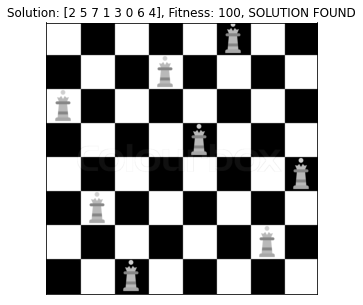

In [19]:
# Variables a utilizar.
N = 30
G = 2000
Pr = 0.4
Pm = 0.3

# Llamar función del algoritmo genético.
elite = geneticAlgorithm(N, G, Pr, Pm)